# EfficientNet-B0 on CIFAR-100, Food-101, Fashion-MNIST, and QMNIST

This notebook trains and evaluates EfficientNet-B0 on four datasets:
- CIFAR-100
- Food-101
- Fashion-MNIST
- QMNIST

We use ImageNet-pretrained EfficientNet-B0 from torchvision, fine-tune the classifier
for each dataset, and compare accuracy, model size, and CPU inference latency.
No quantization is used here.


In [2]:
import os
import time
from typing import Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

import numpy as np
import pandas as pd

In [3]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
DATA_ROOT = "./data"
MODEL_DIR = "./models_efficientnet_only"
os.makedirs(MODEL_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 10          # increase later if you want better accuracy
LEARNING_RATE = 1e-3
IMAGE_SIZE = 224         # EfficientNet-B0 default

# Datasets to run
DATASETS = ["cifar100", "food101", "fashion_mnist", "qmnist"]


Using device: cuda


In [4]:
# Dataset metadata
DATASET_CONFIG = {
    "cifar100": {
        "num_classes": 100,
        "is_grayscale": False,
    },
    "food101": {
        "num_classes": 101,
        "is_grayscale": False,
    },
    "fashion_mnist": {
        "num_classes": 10,
        "is_grayscale": True,
    },
    "qmnist": {
        "num_classes": 10,   # digits 0–9
        "is_grayscale": True,
    },
}


def get_transforms(is_grayscale: bool, train: bool = True):
    """
    Create transforms for a given dataset.
    - Convert grayscale → RGB if needed
    - Resize to 224x224
    - Apply light augmentation for train
    """
    tfms = []

    if is_grayscale:
        tfms.append(transforms.Grayscale(num_output_channels=3))

    if train:
        tfms.extend([
            transforms.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),
            transforms.RandomResizedCrop(IMAGE_SIZE),
            transforms.RandomHorizontalFlip(),
        ])
    else:
        tfms.append(transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)))

    tfms.append(transforms.ToTensor())

    # ImageNet normalization (works well for pretrained EfficientNet)
    tfms.append(
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    )

    return transforms.Compose(tfms)


In [5]:
def get_dataloaders(dataset_name: str,
                    batch_size: int = BATCH_SIZE
                   ) -> Tuple[DataLoader, DataLoader, int]:
    """
    Returns train_loader, test_loader, num_classes for the chosen dataset.
    """
    cfg = DATASET_CONFIG[dataset_name]
    is_gray = cfg["is_grayscale"]
    num_classes = cfg["num_classes"]

    train_tfms = get_transforms(is_grayscale=is_gray, train=True)
    test_tfms  = get_transforms(is_grayscale=is_gray, train=False)

    if dataset_name == "cifar100":
        train_set = datasets.CIFAR100(
            root=DATA_ROOT, train=True, download=True, transform=train_tfms
        )
        test_set = datasets.CIFAR100(
            root=DATA_ROOT, train=False, download=True, transform=test_tfms
        )

    elif dataset_name == "food101":
        train_set = datasets.Food101(
            root=DATA_ROOT, split="train", download=True, transform=train_tfms
        )
        test_set = datasets.Food101(
            root=DATA_ROOT, split="test", download=True, transform=test_tfms
        )

    elif dataset_name == "fashion_mnist":
        train_set = datasets.FashionMNIST(
            root=DATA_ROOT, train=True, download=True, transform=train_tfms
        )
        test_set = datasets.FashionMNIST(
            root=DATA_ROOT, train=False, download=True, transform=test_tfms
        )

    elif dataset_name == "qmnist":
        train_set = datasets.QMNIST(
            root=DATA_ROOT, what="train", download=True, transform=train_tfms
        )
        test_set = datasets.QMNIST(
            root=DATA_ROOT, what="test10k", download=True, transform=test_tfms
        )

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=4, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False,
        num_workers=4, pin_memory=True
    )

    return train_loader, test_loader, num_classes


In [6]:
def create_efficientnet_b0(num_classes: int,
                           pretrained: bool = True) -> nn.Module:
    """
    Load EfficientNet-B0 (ImageNet weights) and replace classifier for num_classes.
    """
    if pretrained:
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
    else:
        weights = None

    model = efficientnet_b0(weights=weights)

    # classifier = nn.Sequential(Dropout, Linear(1280 -> 1000))
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    loss = running_loss / total
    acc = correct / total
    return loss, acc


def train_model(model, train_loader, test_loader,
                num_epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(1, num_epochs + 1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        test_loss, test_acc = evaluate(model, test_loader, device)
        dt = time.time() - t0

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(
            f"Epoch [{epoch}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} "
            f"({dt:.1f}s)"
        )

    return model, history


In [8]:
@torch.no_grad()
def measure_latency(model, loader,
                    num_batches: int = 10,
                    device_str: str = "cpu"):
    """
    Rough latency estimate (ms per batch) on CPU.
    """
    model.eval()
    d = torch.device(device_str)
    model.to(d)

    # warm-up
    imgs, _ = next(iter(loader))
    imgs = imgs.to(d)
    for _ in range(3):
        _ = model(imgs)

    times = []
    for i, (imgs, _) in enumerate(loader):
        if i >= num_batches:
            break
        imgs = imgs.to(d)
        t0 = time.time()
        _ = model(imgs)
        times.append((time.time() - t0) * 1000.0)

    return float(np.mean(times)), float(np.std(times))


In [9]:
results = []

for dname in DATASETS:
    print("\n" + "="*70)
    print(f"Dataset: {dname}")
    print("="*70)

    # 1. Data
    train_loader, test_loader, num_classes = get_dataloaders(dname, batch_size=BATCH_SIZE)
    print(f"{dname}: num_classes={num_classes}")

    # 2. Model
    model = create_efficientnet_b0(num_classes=num_classes, pretrained=True)

    # 3. Train FP32 EfficientNet
    model, history = train_model(model, train_loader, test_loader)

    # 4. Save model
    fp32_path = os.path.join(MODEL_DIR, f"{dname}_efficientnet_b0_fp32.pth")
    torch.save(model.state_dict(), fp32_path)
    print(f"Saved model to: {fp32_path}")

    # 5. Final evaluation
    test_loss, test_acc = evaluate(model, test_loader, device)
    latency_mean, latency_std = measure_latency(
        model, test_loader, num_batches=10, device_str="cpu"
    )

    # 6. Model size
    size_mb = os.path.getsize(fp32_path) / (1024 ** 2)

    results.append({
        "dataset": dname,
        "model": "EfficientNet-B0 (FP32)",
        "test_loss": test_loss,
        "test_acc": test_acc,
        "size_mb": size_mb,
        "latency_ms_per_batch_cpu": latency_mean,
    })

results_df = pd.DataFrame(results)
results_df



Dataset: cifar100
cifar100: num_classes=100
Epoch [1/10] Train Loss: 2.1550 | Train Acc: 0.4458 | Test Loss: 1.1606 | Test Acc: 0.6617 (52.0s)
Epoch [2/10] Train Loss: 1.5032 | Train Acc: 0.5901 | Test Loss: 0.9259 | Test Acc: 0.7264 (49.9s)
Epoch [3/10] Train Loss: 1.3273 | Train Acc: 0.6358 | Test Loss: 0.8664 | Test Acc: 0.7463 (50.0s)
Epoch [4/10] Train Loss: 1.2124 | Train Acc: 0.6652 | Test Loss: 0.8242 | Test Acc: 0.7610 (49.8s)
Epoch [5/10] Train Loss: 1.1361 | Train Acc: 0.6832 | Test Loss: 0.8060 | Test Acc: 0.7662 (49.9s)
Epoch [6/10] Train Loss: 1.0699 | Train Acc: 0.7003 | Test Loss: 0.7530 | Test Acc: 0.7854 (49.9s)
Epoch [7/10] Train Loss: 1.0311 | Train Acc: 0.7121 | Test Loss: 0.7755 | Test Acc: 0.7811 (49.7s)
Epoch [8/10] Train Loss: 0.9759 | Train Acc: 0.7255 | Test Loss: 0.7490 | Test Acc: 0.7900 (49.9s)
Epoch [9/10] Train Loss: 0.9520 | Train Acc: 0.7345 | Test Loss: 0.7684 | Test Acc: 0.7853 (49.7s)
Epoch [10/10] Train Loss: 0.9077 | Train Acc: 0.7430 | Test Loss

,dataset,model,test_loss,test_acc,size_mb,latency_ms_per_batch_cpu
0,cifar100,EfficientNet-B0 (FP32),0.769635,0.789300,16.068759,806.588006
1,food101,EfficientNet-B0 (FP32),0.657902,0.821782,16.073293,824.102807
2,fashion_mnist,EfficientNet-B0 (FP32),0.186578,0.934300,15.630868,832.743025
3,qmnist,EfficientNet-B0 (FP32),0.032135,0.989700,15.628242,829.536343


In [10]:
print(results_df.to_string(index=False))

      dataset                  model  test_loss  test_acc   size_mb  latency_ms_per_batch_cpu
     cifar100 EfficientNet-B0 (FP32)   0.769635  0.789300 16.068759                806.588006
      food101 EfficientNet-B0 (FP32)   0.657902  0.821782 16.073293                824.102807
fashion_mnist EfficientNet-B0 (FP32)   0.186578  0.934300 15.630868                832.743025
       qmnist EfficientNet-B0 (FP32)   0.032135  0.989700 15.628242                829.536343


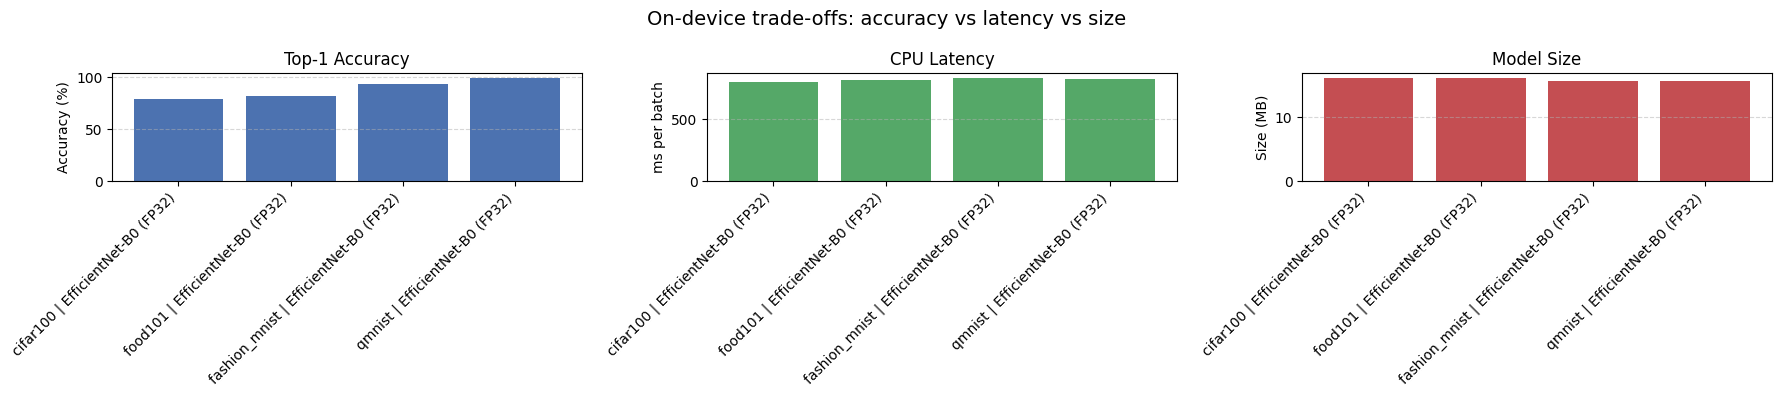

,dataset,model,test_loss,test_acc,size_mb,latency_ms_per_batch_cpu,label
0,cifar100,EfficientNet-B0 (FP32),0.769635,0.789300,16.068759,806.588006,cifar100 | EfficientNet-B0 (FP32)
1,food101,EfficientNet-B0 (FP32),0.657902,0.821782,16.073293,824.102807,food101 | EfficientNet-B0 (FP32)
2,fashion_mnist,EfficientNet-B0 (FP32),0.186578,0.934300,15.630868,832.743025,fashion_mnist | EfficientNet-B0 (FP32)
3,qmnist,EfficientNet-B0 (FP32),0.032135,0.989700,15.628242,829.536343,qmnist | EfficientNet-B0 (FP32)


In [11]:
# Visualize accuracy, CPU latency, and model size across datasets/models
import matplotlib.pyplot as plt
import numpy as np


# Guard against empty results
if results_df.empty:
    print("No results to visualize yet. Run training first.")
else:
    df_plot = results_df.copy()
    df_plot["label"] = df_plot["dataset"] + " | " + df_plot["model"]
    x = np.arange(len(df_plot))
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))


    # Accuracy
    axes[0].bar(x, df_plot["test_acc"] * 100.0, color="#4c72b0")
    axes[0].set_title("Top-1 Accuracy")
    axes[0].set_ylabel("Accuracy (%)")


    # Latency
    axes[1].bar(x, df_plot["latency_ms_per_batch_cpu"], color="#55a868")
    axes[1].set_title("CPU Latency")
    axes[1].set_ylabel("ms per batch")


    # Model size
    axes[2].bar(x, df_plot["size_mb"], color="#c44e52")
    axes[2].set_title("Model Size")
    axes[2].set_ylabel("Size (MB)")


    for ax in axes:
        ax.set_xticks(x)
        ax.set_xticklabels(df_plot["label"], rotation=45, ha="right")
        ax.grid(axis="y", linestyle="--", alpha=0.5)


    fig.suptitle("On-device trade-offs: accuracy vs latency vs size", fontsize=14)
    plt.tight_layout()
    plt.show()


    display(df_plot)